In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize, signal
from sklearn import metrics
from sklearn.linear_model import LinearRegression

$$\mathrm{A \underset{Ni}{\overset{k_1}{\longrightarrow}} B + C}$$

$$r = k_1 \theta_A = k_1\frac{aA}{1 + aA + bB + cC}$$

$$r = \frac{1}{V}\frac{\mathrm{d}\xi}{\mathrm{d}t} \simeq k_1\frac{aA}{aA + bB} = k\frac{a(n_0 - \xi)}{a(n_0 - \xi) + b\xi}$$

$$\int\limits_0^\xi\left(1 + \frac{b\xi}{a(n_0-\xi)}\right)\mathrm{d}\xi = \int\limits_0^t k_1V\mathrm{d}t$$

$$\left(1 - \frac{b}{a}\right)\xi - n_0\frac{b}{a}\ln\left|\frac{n_0 - \xi}{n_0}\right| = k_1Vt$$

$$ t(\xi) = \frac{1}{k_1}(1-k_2) \frac{\xi}{V} + \frac{k_2}{k_1}\left(-\frac{n_0}{V}\right)\ln\left|\frac{n_0 - \xi}{n_0}\right| = c_1 x_1(\xi) + c_2 x_2(\xi)$$

$$k_1 = \frac{1}{c_1 + c_2} \,,\quad k_2 = \frac{c_2}{c_1 + c_2}$$

$$r = k_1\frac{aA}{aA + bB} \rightarrow \frac{1}{r} = \frac{1}{k_1}\left(1 + k_2 \frac{\xi}{n_0 - \xi}\right) $$

In [2]:
df = pd.read_excel("cathet.xlsx")

In [3]:
df = df.loc[2:]

In [4]:
df["t"] = df["t"] - df.loc[2, "t"]
df["V"] = df["V"] - df.loc[2, "V"]

In [5]:
df[:5]

,t,V
2,0,0.000000
3,39,0.000008
4,131,0.000027
5,184,0.000038
6,214,0.000044


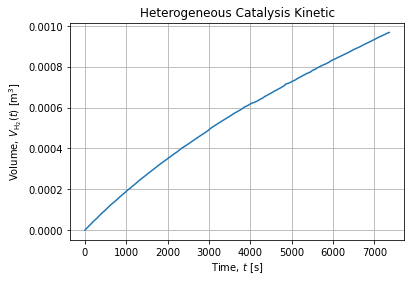

In [6]:
fig, axe = plt.subplots()
axe.plot(df["t"], df["V"])
axe.set_title("Heterogeneous Catalysis Kinetic")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel("Volume, $V_\mathrm{H_2}(t)$ $[\mathrm{m^3}]$")
axe.grid()

In [7]:
R = 8.31446261815324  # J/mol.K
T0 = 292.05           # K
p0 = 101600           # Pa
V = 190e-6            # m3 of isopropanol
m = 2.7677            # g of Raney Nickel
rho = 785             # kg/m³
M = 60.1              # g/mol
n0 = 1000*rho*V/M     # mol

In [8]:
n0

2.4816971713810316

In [9]:
df["xi"] = p0*df["V"]/(R*T0)
df["B/A"] = df["xi"]/(n0 - df["xi"])
df["x1"] = df["xi"]/V
df["x2"] = -(n0/V)*np.log(np.abs((n0 - df["xi"])/n0))
df["dxidt1"] = df["xi"].diff()/df["t"].diff()
df["1/r1"] = V/df["dxidt1"]

In [10]:
df.sample(5)

,t,V,xi,B/A,x1,x2,dxidt1,1/r1
83,4878,0.000716,0.029975,0.012226,157.762685,158.723187,0.000003,57.182935
60,3666,0.000578,0.024180,0.009839,127.262780,127.886817,0.000005,40.301355
63,3904,0.000607,0.025393,0.010338,133.649042,134.337506,0.000003,54.491973
10,322,0.000065,0.002741,0.001106,14.424143,14.432113,0.000011,16.578246
105,6124,0.000846,0.035385,0.014465,186.236603,187.577076,0.000004,46.318177


In [11]:
results = {}

## OLS

In [12]:
XOLS = df[["x1", "x2"]].values
yOLS = df["t"].values

In [13]:
OLS = LinearRegression(fit_intercept=False).fit(XOLS, yOLS)
scoreOLS = OLS.score(XOLS, yOLS)
scoreOLS

0.9999526276968934

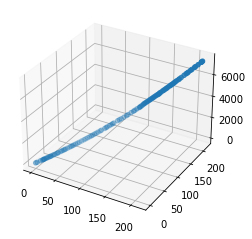

In [14]:
fig = plt.figure()
axe = fig.add_subplot(projection='3d')
axe.scatter(XOLS[:,0], XOLS[:,1], yOLS)

In [15]:
OLS.coef_

array([-1619.94014191,  1640.97679807])

In [16]:
OLS.intercept_

0.0

In [17]:
tOLS = OLS.predict(XOLS)

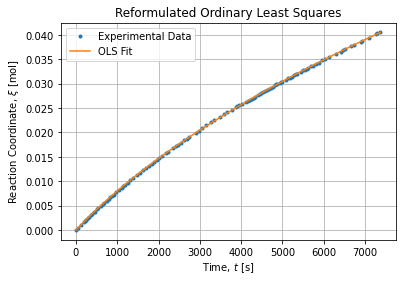

In [18]:
fig, axe = plt.subplots()
axe.plot(df["t"], df["xi"], ".", label="Experimental Data")
axe.plot(tOLS, df["xi"], "-", label="OLS Fit")
axe.set_title("Reformulated Ordinary Least Squares")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ $[\mathrm{mol}]$")
axe.legend()
axe.grid()

In [19]:
def solveOLS(c1, c2):
    k1 = 1./(c1 + c2)
    k2 = c2*k1
    return k1, k2

In [20]:
k1OLS, k2OLS = solveOLS(*OLS.coef_)
k1OLS, k2OLS

(0.04753607191540943, 78.00559108463023)

In [21]:
k1OLS*V/m # mol/s

3.2633065953419057e-06

In [22]:
results["OLS"] = {
    "k1": k1OLS, "k2": k2OLS,
    "MSE": metrics.mean_squared_error(yOLS, tOLS),
    "r2": metrics.r2_score(yOLS, tOLS)
}
results["OLS"]

{'k1': 0.04753607191540943,
 'k2': 78.00559108463023,
 'MSE': 220.70733391613194,
 'r2': 0.9999526276968934}

## Lineweaver-Burk

In [23]:
XLB = df[["B/A"]].values[1:]
yLB = df["1/r1"].values[1:]
LB = LinearRegression(fit_intercept=True).fit(XLB, yLB)
LB.score(XLB, yLB)

0.565121006848629

In [24]:
LB.coef_, LB.intercept_

(array([1664.13293139]), 21.268198300365704)

In [25]:
XLBmax = np.linspace(df["B/A"].min(), df["B/A"].max(), 2).reshape(-1, 1)
yLBhat = LB.predict(XLB)

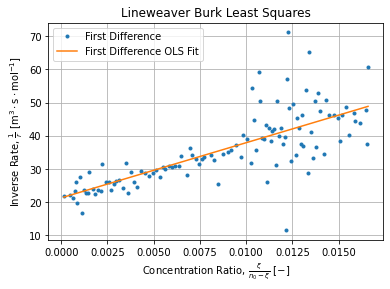

In [26]:
fig, axe = plt.subplots()
axe.plot(df["B/A"], df["1/r1"], ".", label="First Difference")
axe.plot(XLB, yLBhat, label="First Difference OLS Fit")
axe.set_title("Lineweaver Burk Least Squares")
axe.set_xlabel(r"Concentration Ratio, $\frac{\xi}{n_0 - \xi}$ $[-]$")
axe.set_ylabel(r"Inverse Rate, $\frac{1}{r}$ $[\mathrm{m^3\cdot s \cdot mol^{-1}]}$")
axe.legend()
axe.grid()

In [27]:
k1LB = 1/LB.intercept_
k2LB = LB.coef_[0]*k1LB
k1LB, k2LB

(0.04701855727867674, 78.2451295537145)

In [28]:
results["LB"] = {
    "k1": k1LB, "k2": k2LB,
    "MSE": metrics.mean_squared_error(yLB, yLBhat),
    "r2": metrics.r2_score(yLB, yLBhat)
}
results["LB"]

{'k1': 0.04701855727867674,
 'k2': 78.2451295537145,
 'MSE': 49.8171431042655,
 'r2': 0.565121006848629}

### LMA

In [29]:
def factory(n0, V):
    def wrapped(xi, k1, k2):
        return (1-k2)/k1*(xi/V) - (k2/k1)*(n0/V)*np.log((n0 - xi)/n0)
    return wrapped

In [30]:
objective = factory(n0, V)

In [31]:
parameters, covariance = optimize.curve_fit(objective, df["xi"], df["t"])
parameters, covariance

(array([4.75360716e-02, 7.80055896e+01]),
 array([[1.21265292e-08, 5.87172563e-05],
        [5.87172563e-05, 2.90824476e-01]]))

In [32]:
that = objective(df["xi"], *parameters)

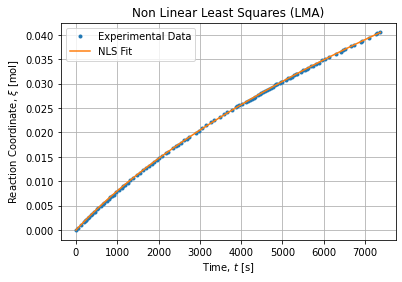

In [33]:
fig, axe = plt.subplots()
axe.plot(df["t"], df["xi"], ".", label="Experimental Data")
axe.plot(that, df["xi"], "-", label="NLS Fit")
axe.set_title("Non Linear Least Squares (LMA)")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ $[\mathrm{mol}]$")
axe.legend()
axe.grid()

In [34]:
results["LMA"] = {
    "k1": parameters[0], "k2": parameters[1],
    "MSE": metrics.mean_squared_error(df["t"], that),
    "r2": metrics.r2_score(df["t"], that)
}
results["LMA"]

{'k1': 0.04753607161313695,
 'k2': 78.00558959396061,
 'MSE': 220.70733391605376,
 'r2': 0.9999526276968934}

In [35]:
pd.DataFrame(results)

,OLS,LB,LMA
k1,0.047536,0.047019,0.047536
k2,78.005591,78.245130,78.005590
MSE,220.707334,49.817143,220.707334
r2,0.999953,0.565121,0.999953


In [36]:
from sklearn import covariance

C = covariance.EmpiricalCovariance()
C.fit(np.array([df["t"], that]).T)

EmpiricalCovariance()

In [37]:
C.covariance_

array([[4658995.22384067, 4663604.29464849],
       [4663604.29464849, 4668432.03575752]])

## LBP3

In [38]:
from sklearn import preprocessing

XP3 = df["t"].values.reshape(-1, 1)
yP3 = df["xi"].values
XP3f = preprocessing.PolynomialFeatures(degree=3).fit_transform(XP3)
P3 = LinearRegression(fit_intercept=False).fit(XP3f, yP3)
P3.score(XP3f, yP3)

0.9999757901850856

In [39]:
yP3hat = P3.predict(XP3f)

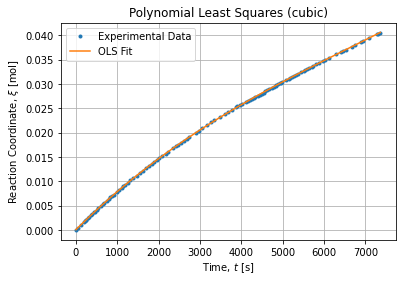

In [40]:
fig, axe = plt.subplots()
axe.plot(df["t"], df["xi"], ".", label="Experimental Data")
axe.plot(XP3, yP3hat, "-", label="OLS Fit")
axe.set_title("Polynomial Least Squares (cubic)")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ $[\mathrm{mol}]$")
axe.legend()
axe.grid()

In [41]:
dCdt = np.diff(yP3hat)/df["t"].diff().values[1:]/V

In [42]:
XLBP3 = df["B/A"].values[1:].reshape(-1, 1)
yLBP3 = 1/dCdt
LBP3 = LinearRegression(fit_intercept=True).fit(XLBP3, yLBP3)
LBP3.score(XLBP3, yLBP3)

0.9867652081793257

In [43]:
yLBP3hat = LBP3.predict(XLBP3)

In [44]:
k1LBP3 = 1/LBP3.intercept_
k2LBP3 = LBP3.coef_[0]*k1LBP3
k1LBP3, k2LBP3

(0.04669577001727265, 74.17088195955405)

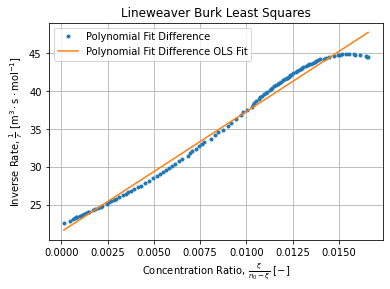

In [45]:
fig, axe = plt.subplots()
axe.plot(XLBP3, yLBP3, ".", label="Polynomial Fit Difference")
axe.plot(XLBP3, yLBP3hat, label="Polynomial Fit Difference OLS Fit")
ylim = axe.get_ylim()
#axe.plot(df["B/A"], df["1/r1"], ".", color="lightgray", label="First Difference")
#axe.plot(XLB, yLBhat, color="gray", label="First Difference OLS Fit")
axe.set_ylim(ylim)
axe.set_title("Lineweaver Burk Least Squares")
axe.set_xlabel(r"Concentration Ratio, $\frac{\xi}{n_0 - \xi}$ $[-]$")
axe.set_ylabel(r"Inverse Rate, $\frac{1}{r}$ $[\mathrm{m^3\cdot s \cdot mol^{-1}]}$")
axe.legend()
axe.grid()

In [46]:
results["LBP3"] = {
    "k1": k1LBP3, "k2": k2LBP3,
    "MSE": metrics.mean_squared_error(yLBP3, yLBP3hat),
    "r2": metrics.r2_score(yLBP3, yLBP3hat)
}
results["LBP3"]

{'k1': 0.04669577001727265,
 'k2': 74.17088195955405,
 'MSE': 0.7910262572186871,
 'r2': 0.9867652081793257}

# LBMan

In [47]:
df2 = pd.read_excel("cathet.xlsx", sheet_name="Manual")
df2["keep"] = True

In [48]:
df2["1/v"] *= V

In [49]:
df2.loc[0, "1/v"] = 22.45
df2.loc[4, "1/v"] = 32.45

In [50]:
df2.loc[0, "keep"] = False
df2.loc[4, "keep"] = False

In [51]:
#df2 = df2[df2["keep"]]
#df2

In [52]:
df2["1/v"] *= 1.1

In [53]:
XLBM = df2["bP/bR"].values[:-1].reshape(-1, 1)
yLBM = df2["1/v"].values[:-1]
LBM = LinearRegression(fit_intercept=True).fit(XLBM, yLBM)
LBM.score(XLBM, yLBM)

0.984458468896565

In [54]:
yLBMhat = LBM.predict(XLBM)

In [55]:
k1LBM = 1/LBM.intercept_
k2LBM = LBM.coef_[0]*k1LBM
k1LBM, k2LBM

(0.047296065060717624, 73.76063697071173)

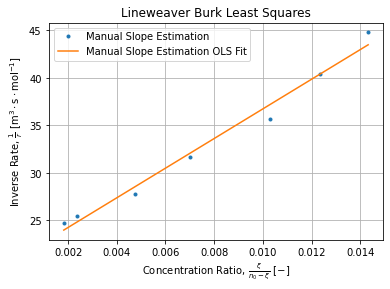

In [56]:
fig, axe = plt.subplots()
axe.plot(XLBM, yLBM, ".", label="Manual Slope Estimation")
axe.plot(XLBM, yLBMhat, label="Manual Slope Estimation OLS Fit")
axe.set_title("Lineweaver Burk Least Squares")
axe.set_xlabel(r"Concentration Ratio, $\frac{\xi}{n_0 - \xi}$ $[-]$")
axe.set_ylabel(r"Inverse Rate, $\frac{1}{r}$ $[\mathrm{m^3\cdot s \cdot mol^{-1}]}$")
axe.legend()
axe.grid()

In [57]:
results["LBM"] = {
    "k1": k1LBM, "k2": k2LBM,
    "MSE": metrics.mean_squared_error(yLBM, yLBMhat),
    "r2": metrics.r2_score(yLBM, yLBMhat)
}
results["LBM"]

{'k1': 0.047296065060717624,
 'k2': 73.76063697071173,
 'MSE': 0.7926235236812226,
 'r2': 0.984458468896565}

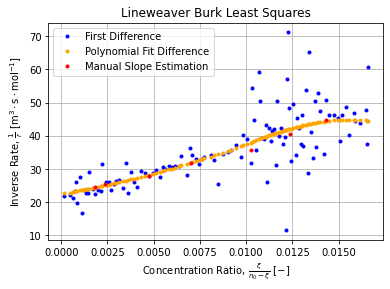

In [58]:
fig, axe = plt.subplots()
axe.plot(df["B/A"], df["1/r1"], ".", color="blue", label="First Difference")
#axe.plot(XLB, yLBhat, color="blue", label="First Difference OLS Fit")
axe.plot(XLBP3, yLBP3, ".", color="orange", label="Polynomial Fit Difference")
#axe.plot(XLBP3, yLBP3hat, color="darkorange", label="Polynomial Fit Difference OLS Fit")
axe.plot(XLBM, yLBM, ".", color="red", label="Manual Slope Estimation")
#axe.plot(XLBM, yLBMhat, color="green", label="Manual Slope Estimation OLS Fit")
#axe.set_ylim([20, 50])
axe.set_title("Lineweaver Burk Least Squares")
axe.set_xlabel(r"Concentration Ratio, $\frac{\xi}{n_0 - \xi}$ $[-]$")
axe.set_ylabel(r"Inverse Rate, $\frac{1}{r}$ $[\mathrm{m^3\cdot s \cdot mol^{-1}]}$")
axe.legend() # bbox_to_anchor=(1,1))
axe.grid()

In [59]:
final = pd.DataFrame(results).T
final

,k1,k2,MSE,r2
OLS,0.047536,78.005591,220.707334,0.999953
LB,0.047019,78.245130,49.817143,0.565121
LMA,0.047536,78.005590,220.707334,0.999953
LBP3,0.046696,74.170882,0.791026,0.986765
LBM,0.047296,73.760637,0.792624,0.984458


In [60]:
def regmse(x):
    that = objective(df["xi"], x["k1"], x["k2"])
    mse = metrics.mean_squared_error(df["t"], that)
    score = metrics.r2_score(df["t"], that)
    return pd.Series({"Fit MSE": mse, "Fit Score": score})

In [61]:
final = pd.concat([final, final.apply(regmse, axis=1)], axis=1)

In [62]:
final

,k1,k2,MSE,r2,Fit MSE,Fit Score
OLS,0.047536,78.005591,220.707334,0.999953,220.707334,0.999953
LB,0.047019,78.245130,49.817143,0.565121,2554.580075,0.999452
LMA,0.047536,78.005590,220.707334,0.999953,220.707334,0.999953
LBP3,0.046696,74.170882,0.791026,0.986765,354.412567,0.999924
LBM,0.047296,73.760637,0.792624,0.984458,3083.989339,0.999338


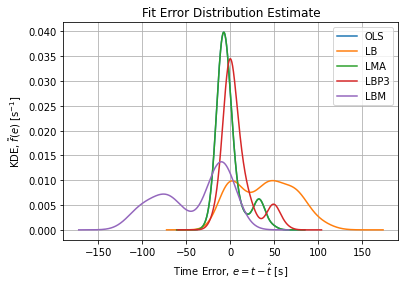

In [71]:
fig, axe = plt.subplots()
for x in final.reset_index().to_dict(orient="records"):
    that = objective(df["xi"], x["k1"], x["k2"])
    (that - df["t"]).plot(kind="kde", ax=axe, label=x["index"])
axe.set_title("Fit Error Distribution Estimate")
axe.set_xlabel(r"Time Error, $e = t - \hat{t}$ $[\mathrm{s}]$")
axe.set_ylabel(r"KDE, $\tilde{f}(e)$ $[\mathrm{s^{-1}}]$")
axe.legend()
axe.grid()